### Imports

In [1]:
#importing things
import pandas as pd
import numpy as np
import csv
import pylab as pl
import matplotlib.pyplot as plt
import copy
import scipy
from collections import OrderedDict
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.special import comb
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.lines as lines

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'xtick.labelsize': 7})
plt.rcParams.update({'ytick.labelsize': 7})
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['axes.linewidth'] = 0.5

### Load first order coefficients

In [2]:
h1_linear = pd.read_table('../../CR9114/Epistasis_linear_models/model_coefs/H1_5order_biochem.txt',names=['Term','H1_Effect','H1_SE','H1_95CI_low','H1_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
h1_fil = h1_linear[~h1_linear["Term"].str.contains(',')]
h3_linear = pd.read_table('../../CR9114/Epistasis_linear_models/model_coefs/H3_4order_biochem.txt',names=['Term','H3_Effect','H3_SE','H3_95CI_low','H3_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
h3_fil = h3_linear[~h3_linear["Term"].str.contains(',')]
first_order = pd.merge(h1_fil,h3_fil,on='Term',how='outer')
first_order.fillna(1.4,inplace=True)
first_order['Term'] = first_order['Term'].replace({'1':'30','2':'35','3':'36','4':'57','5':'64','6':'65','7':'66','8':'79','9':'82','10':'83','11':'84','12':'85','13':'92','14':'95','15':'103','16':'113'})
first_order.head()

,Term,H1_Effect,H1_SE,H1_95CI_low,H1_95CI_hi,H3_Effect,H3_SE,H3_95CI_low,H3_95CI_hi
0,30,-0.872758,0.038527,4.034908e-113,-1.045602,0.049518,0.042891,0.248329,-0.125429
1,35,0.031795,0.038005,4.028223e-01,-0.138705,-0.007709,0.042891,0.857369,-0.182655
2,36,0.204205,0.038007,7.782075e-08,0.033695,-0.033065,0.042891,0.440779,-0.208012
3,57,-0.112460,0.037995,3.078748e-03,-0.282914,1.400000,1.400000,1.400000,1.400000
4,64,0.095328,0.038149,1.246353e-02,-0.075819,0.105024,0.042891,0.014363,-0.069922


### Load structure with selected regions and mutated residues

In [3]:
#pick an antigen
antigen = "H1"

#import stuff
from pymol import cmd
#load pdb
#using 4FQI: Crystal Structure of Fab CR9114 in Complex with a H5N1 influenza virus hemagglutinin, res=1.71A
if antigen == "H1":
    cmd.fetch('4FQI')
    cmd.hide('everything')
    ##########################
    #rename chains and sugars for individual selections
    #H5 chains
    monoA1 = cmd.select('monoA1', 'chain A')
    monoA2 = cmd.select('monoA2', 'chain B')
    HA = cmd.select('HA', 'chain A or chain B')
    #Fab CR9114 chains
    HC = cmd.select('HC', 'chain H')
    LC = cmd.select('LC', 'chain L')
    Ab = cmd.select('Ab', 'chain H or chain L')
    #sugars
    sugars = cmd.select('sugars', 'resn EDO or resn NAG or resn GOL')
    #create selections for regions of antibody heavy chain
    HCDR1 = cmd.select('HCDR1',('chain H and resi 26-33'))
    HCDR2 = cmd.select('HCDR2',('chain H and resi 51-57'))
    HCDR3 = cmd.select('HCDR3',('chain H and resi 92-103'))
    FW1 = cmd.select('FW1',('chain H and resi 1-25'))
    FW2 = cmd.select('FW2',('chain H and resi 34-50'))
    FW3 = cmd.select('FW3',('chain H and resi 58-91'))
    FW4 = cmd.select('FW4',('chain H and resi 104-113'))
    #create selections for mutated residues
    mut1 = cmd.select('mut30',('chain H and resi 29'))
    mut2 = cmd.select('mut35',('chain H and resi 30'))
    mut3 = cmd.select('mut36',('chain H and resi 31'))
    mut4 = cmd.select('mut57',('chain H and resi 52'))
    mut5 = cmd.select('mut64',('chain H and resi 56'))
    mut6 = cmd.select('mut65',('chain H and resi 57'))
    mut7 = cmd.select('mut66',('chain H and resi 58'))
    mut8 = cmd.select('mut79',('chain H and resi 70'))
    mut9 = cmd.select('mut82',('chain H and resi 73'))
    mut10 = cmd.select('mut83',('chain H and resi 74'))
    mut11 = cmd.select('mut84',('chain H and resi 75'))
    mut12 = cmd.select('mut85',('chain H and resi 76'))
    mut13 = cmd.select('mut92',('chain H and resi 82A'))
    mut14 = cmd.select('mut95',('chain H and resi 83'))
    mut15 = cmd.select('mut103',('chain H and resi 91'))
    mut16 = cmd.select('mut113',('chain H and resi 100B'))
    mutations = ['mut30','mut35','mut36','mut57','mut64','mut65','mut66','mut79','mut82','mut83','mut84','mut85','mut92','mut95','mut103','mut113']
    allmut = cmd.select('allmut',('chain H and (resi 29 or resi 30 or resi 31 or resi 52 or resi 56 or resi 57 or resi 58 or resi 70 or resi 73 or resi 74 or resi 75 or resi 76 or resi 82A or resi 83 or resi 91 or resi 100B)'))
    location = ['HCDR1','HCDR1','HCDR1','HCDR2','HCDR2','HCDR2','FW3','FW3','FW3','FW3','FW3','FW3','FW3','FW3','FW3','HCDR3']
    ##########################
    #display
    #HA
    cmd.show_as('cartoon',"monoA1")
    cmd.color('gray30', "monoA1")
    cmd.show_as('cartoon',"monoA2")
    cmd.color('gray50', "monoA2")
    cmd.show_as('sticks', "sugars")
    cmd.color('black', "sugars")
    #CR9114 FAB
    cmd.show_as('cartoon',"HC")
    cmd.color('firebrick', "HC")
    cmd.show_as('cartoon',"LC")
    cmd.color('tv_blue', "LC")
    cmd.show_as('spheres',"allmut")
    cmd.color('forest', "allmut")
    cmd.orient()
    #save image if desired
    cmd.png('/tmp/foo.png', ray=1)
    from IPython.display import Image
    Image(filename='/tmp/foo.png')
elif antigen == "H3":
    cmd.fetch('4FQY')
    cmd.hide('everything')
    ##########################
    #rename chains and sugars for individual selections
    #H5 chains
    monoA1 = cmd.select('monoA1', 'chain A')
    monoA2 = cmd.select('monoA2', 'chain B')
    HA = cmd.select('HA', 'chain A or chain B')
    #Fab CR9114 chains
    HC = cmd.select('HC', 'chain H')
    LC = cmd.select('LC', 'chain L')
    Ab = cmd.select('Ab', 'chain H or chain L')
    #sugars
    sugars = cmd.select('sugars', 'resn EDO or resn NAG or resn GOL')
    #create selections for regions of antibody heavy chain
    HCDR1 = cmd.select('HCDR1',('chain H and resi 26-33'))
    HCDR2 = cmd.select('HCDR2',('chain H and resi 51-57'))
    HCDR3 = cmd.select('HCDR3',('chain H and resi 92-103'))
    FW1 = cmd.select('FW1',('chain H and resi 1-25'))
    FW2 = cmd.select('FW2',('chain H and resi 34-50'))
    FW3 = cmd.select('FW3',('chain H and resi 58-91'))
    FW4 = cmd.select('FW4',('chain H and resi 104-113'))
    #create selections for mutated residues
    mut1 = cmd.select('mut30',('chain H and resi 29'))
    mut2 = cmd.select('mut35',('chain H and resi 30'))
    mut3 = cmd.select('mut36',('chain H and resi 31'))
    mut4 = cmd.select('mut57',('chain H and resi 52'))
    mut5 = cmd.select('mut64',('chain H and resi 56'))
    mut6 = cmd.select('mut65',('chain H and resi 57'))
    mut7 = cmd.select('mut66',('chain H and resi 58'))
    mut8 = cmd.select('mut79',('chain H and resi 70'))
    mut9 = cmd.select('mut82',('chain H and resi 73'))
    mut10 = cmd.select('mut83',('chain H and resi 74'))
    mut11 = cmd.select('mut84',('chain H and resi 75'))
    mut12 = cmd.select('mut85',('chain H and resi 76'))
    mut13 = cmd.select('mut92',('chain H and resi 82A'))
    mut14 = cmd.select('mut95',('chain H and resi 83'))
    mut15 = cmd.select('mut103',('chain H and resi 91'))
    mut16 = cmd.select('mut113',('chain H and resi 100B'))
    mutations = ['mut30','mut35','mut36','mut57','mut64','mut65','mut66','mut79','mut82','mut83','mut84','mut85','mut92','mut95','mut103','mut113']
    allmut = cmd.select('allmut',('chain H and (resi 29 or resi 30 or resi 31 or resi 52 or resi 56 or resi 57 or resi 58 or resi 70 or resi 73 or resi 74 or resi 75 or resi 76 or resi 82A or resi 83 or resi 91 or resi 100B)'))
    location = ['HCDR1','HCDR1','HCDR1','HCDR2','HCDR2','HCDR2','FW3','FW3','FW3','FW3','FW3','FW3','FW3','FW3','FW3','HCDR3']
    ##########################
    #display
    #HA
    cmd.show_as('cartoon',"monoA1")
    cmd.color('gray30', "monoA1")
    cmd.show_as('cartoon',"monoA2")
    cmd.color('gray50', "monoA2")
    cmd.show_as('sticks', "sugars")
    cmd.color('black', "sugars")
    #CR9114 FAB
    cmd.show_as('cartoon',"HC")
    cmd.color('firebrick', "HC")
    cmd.show_as('cartoon',"LC")
    cmd.color('tv_blue', "LC")
    cmd.show_as('spheres',"allmut")
    cmd.color('forest', "allmut")
    cmd.orient()
    #save image if desired
    cmd.png('/tmp/foo.png', ray=1)
    from IPython.display import Image
    Image(filename='/tmp/foo.png')

 PyMOL not running, entering library mode (experimental)


### Count HA residues with atoms within 6 Angstroms of an atom in each CR-9114 mutated residue

In [4]:
#make a list of positions within a certain distance of other things
#################################################
#intermolecular interaction distances
#hydrogen bond: 4 A
#salt bridge: 4 A
#vWaals: 6 A
#resolution of structure is 1.71 A, so call potential interactions as within 6 A
#################################################
#import things
from pymol import *
distance = 6
neighbors_summary=[]
region='HA'
for mutant in mutations:
    print(mutant)
    focal='%s' % mutant
    selection='br. pol. in ('+str(region)+')within %s of (' % distance +str(focal)+')'
    nearby = cmd.select('nearby',selection) #change focal point here
#print list of these residues
    stored.chains = []
    cmd.iterate('nearby', 'stored.chains.append(chain+resi+resn)')
#################################################
#export to csv file
    contacts=[]
    count = 0
    for i in stored.chains:
        if i not in contacts:
            count = count + 1
            contacts.append(i)
    if region=='HC':
        count = count - 1 #dont want to count the residue of interest
    else:
        count = count
    neighbors_summary.append(count)
    print("There are "+str(count)+" residues with atoms within %s A of " % distance +str(mutant)+" in "+str(region))
    print(contacts)
    import csv
    with open('structure_output/CR9114/CR9114_contacts/%s_residues_near%s.txt' %(antigen,mutant), 'w') as f:
        for item in contacts:
            f.write("%s\n" % item)
print(neighbors_summary)
first_order['contacts_%s' % antigen]=neighbors_summary

mut30
There are 0 residues with atoms within 6 A of mut30 in HA
[]
mut35
There are 3 residues with atoms within 6 A of mut35 in HA
['B45ILE', 'B49THR', 'B53ASN']
mut36
There are 4 residues with atoms within 6 A of mut36 in HA
['B42GLN', 'B45ILE', 'B46ASP', 'B49THR']
mut57
There are 1 residues with atoms within 6 A of mut57 in HA
['B45ILE']
mut64
There are 2 residues with atoms within 6 A of mut64 in HA
['A38HIS', 'B18VAL']
mut65
There are 0 residues with atoms within 6 A of mut65 in HA
[]
mut66
There are 0 residues with atoms within 6 A of mut66 in HA
[]
mut79
There are 0 residues with atoms within 6 A of mut79 in HA
[]
mut82
There are 3 residues with atoms within 6 A of mut82 in HA
['A40GLN', 'B52VAL', 'B53ASN']
mut83
There are 8 residues with atoms within 6 A of mut83 in HA
['A40GLN', 'A41ASP', 'A42ILE', 'A291SER', 'A292MET', 'A293PRO', 'B52VAL', 'B56ILE']
mut84
There are 1 residues with atoms within 6 A of mut84 in HA
['A291SER']
mut85
There are 1 residues with atoms within 6 A of m

### Figure 3c

In [5]:
first_order.to_csv('structure_output/CR9114/firstorder_summary%s.csv'% antigen,index=False)
first_order = pd.DataFrame(pd.read_csv('structure_output/CR9114/firstorder_summary%s.csv'% antigen,delimiter=','))
first_order.replace(to_replace=10, value=1.2,inplace=True)
upper = max(list(first_order['H1_Effect']))
lowerh1 = min(list(first_order['H1_Effect']))
if min(list(first_order['H3_Effect'])) < lowerh1:
    lower= min(list(first_order['H3_Effect']))
else:
    lower=lowerh1

In [6]:
#print commands for mapping onto pymol structure
print('stored.newB='+str(list(first_order["%s_Effect" % antigen]))+'\nalter 9114m, b=0.0\nalter 9114m and n. CA, b=stored.newB.pop(0)\nalphatoall *,b\nspectrum b, blue_white_red, 9114m, minimum=%s, maximum=%s' % (lower,upper))

stored.newB=[-0.8727577508778577, 0.03179473390169018, 0.20420455720374173, -0.11246010558964814, 0.0953279648045542, -0.2113971920909264, -0.20716599081949005, -0.13722990998155382, 0.615065805349558, 0.8854764392940877, -0.05459018860232567, -0.10900280142679376, 0.01550523995906905, 0.009635024097978008, -0.009799156715766366, 0.002399885006930225]
alter 9114m, b=0.0
alter 9114m and n. CA, b=stored.newB.pop(0)
alphatoall *,b
spectrum b, blue_white_red, 9114m, minimum=-0.8727577508778577, maximum=0.8854764392940877


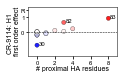

In [6]:
#H1 scatter
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(1.6,0.9))
plt.ylim(-1.6,1.6)
plt.tick_params(labelsize=6,length=2.5,pad=1)
y_locator = FixedLocator([0,1,1.4])
ax.yaxis.set_major_locator(y_locator)
ax.set_yticklabels(['0','1','R'])
if antigen == "H1":
    x_locator = FixedLocator([0,2,4,6,8])
    plt.xlim(-1,9)
    ax.xaxis.set_major_locator(x_locator)
    ax.set_xticklabels(['0','2','4','6','8'])
else:
    x_locator = FixedLocator([0,2,4,6,8,10])
    plt.xlim(-1,11)
    ax.xaxis.set_major_locator(x_locator)
    ax.set_xticklabels(['0','2','4','6','8','10'])
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = cm.get_cmap("bwr")
x=first_order['contacts_%s' % antigen]
y=first_order['%s_Effect' % antigen]
p1=sns.scatterplot(x=x,
            y=y,
            data=first_order,
            palette="bwr",
            hue_norm=(-1,1),
            x_jitter=True,
            marker='o',
            edgecolor='black',
            linewidth=0.25,
            size=4,
            hue='%s_Effect' % antigen)


#sort dataframe to only label outliers
first_order_s = first_order.iloc[(-first_order['%s_Effect' % antigen].abs()).argsort()].reset_index(drop=True)
lim=3
for line in range(0,lim):
    if antigen=="H3":
        ax.text(first_order_s.contacts_H3[line]+0.55, first_order_s.H3_Effect[line], first_order_s.Term[line], horizontalalignment='center', fontsize=6, color='black')
    elif antigen=="H1":
        ax.text(first_order_s.contacts_H1[line]+0.55, first_order_s.H1_Effect[line], first_order_s.Term[line], horizontalalignment='center', fontsize=6, color='black')

#plt.title('%s' % antigen,fontsize=8,weight='bold')
plt.xlabel('# proximal HA residues',fontsize=7,labelpad=0)
plt.legend([],[], frameon=False)

#plt.legend(loc="upper center", bbox_to_anchor=(1.1, 1.1), ncol=1, fontsize=7,markerscale=0.5)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.ylabel('CR-9114: %s \n first order effect' % antigen,fontsize=7,labelpad=0)
plt.savefig('images/9114_%s_linear_contacts.png' % antigen, transparent=True, dpi=600,bbox_inches='tight')

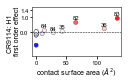

In [21]:
toplot = pd.DataFrame(pd.read_csv('structure_output/CR9114/chimera_buried_H1.csv',delimiter=','))
antigen="H1"
#H1 scatter
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(1.6,0.9))
plt.ylim(-1.6,1.6)
plt.tick_params(labelsize=6,length=2.5,pad=1)
y_locator = FixedLocator([0,1,1.4])
ax.yaxis.set_major_locator(y_locator)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = cm.get_cmap("bwr")
x=toplot['buriedSA_H1']
y=toplot['%s_Effect' % antigen]
p1=sns.scatterplot(x=x,
            y=y,
            data=toplot,
            palette="bwr",
            hue_norm=(-1,1),
            x_jitter=True,
            marker='o',
            edgecolor='black',
            linewidth=0.25,
            size=4,
            hue='%s_Effect' % antigen)


#sort dataframe to only label outliers
toplot_s = toplot.iloc[(-toplot['buriedSA_%s' % antigen].abs()).argsort()].reset_index(drop=True)
lim=6
for line in range(0,lim):
    if antigen=="H3":
        ax.text(toplot_s.buriedSA_H3[line], toplot_s.H3_Effect[line]+0.2, toplot_s.Term[line], horizontalalignment='center', fontsize=6, color='black')
    elif antigen=="H1":
        ax.text(toplot_s.buriedSA_H1[line], toplot_s.H1_Effect[line]+0.2, toplot_s.Term[line], horizontalalignment='center', fontsize=6, color='black')

#plt.title('%s' % antigen,fontsize=8,weight='bold')
plt.xlabel('contact surface area ($\AA^2$)',fontsize=7,labelpad=0)
plt.legend([],[], frameon=False)

#plt.legend(loc="upper center", bbox_to_anchor=(1.1, 1.1), ncol=1, fontsize=7,markerscale=0.5)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.ylabel('CR9114: %s \n first order effect' % antigen,fontsize=7,labelpad=0)
plt.savefig('images/9114_%s_linear_BSA.png' % antigen, transparent=True, dpi=600,bbox_inches='tight')

### Figure 3f

In [3]:
model = "biochem"
plotting = "pairwise"
#import kl second order effects from second order model
mut_names = ['30','35','36','57','64','65','66','79','82','83','84','85','92','95','103','113']
if antigen == "H1":
    h1 = pd.read_table('../../CR9114/Epistasis_linear_models/model_coefs/H1_5order_biochem.txt',names=['Term','H1_Effect','H1_SE','pval','H1_95CI_low','H1_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
    h1['order'] = h1[['Term']].applymap(lambda x: str.count(x, ',')+1)
    h1_pairwise = h1[h1['order']==2]
    h1_pairwise[['Mutation 1','Mutation 2']] = h1_pairwise.Term.str.split(",",expand=True)
    toplot = pd.DataFrame()
    toplot = h1_pairwise[['Mutation 1','Mutation 2','H1_Effect','H1_SE','H1_95CI_low','H1_95CI_hi']].copy()
    toplot['Mutation 1'] = toplot['Mutation 1'].replace({'1':'mut30','2':'mut35','3':'mut36','4':'mut57','5':'mut64','6':'mut65','7':'mut66','8':'mut79','9':'mut82','10':'mut83','11':'mut84','12':'mut85','13':'mut92','14':'mut95','15':'mut103','16':'mut113'})
    toplot['Mutation 2'] = toplot['Mutation 2'].replace({'1':'mut30','2':'mut35','3':'mut36','4':'mut57','5':'mut64','6':'mut65','7':'mut66','8':'mut79','9':'mut82','10':'mut83','11':'mut84','12':'mut85','13':'mut92','14':'mut95','15':'mut103','16':'mut113'})
    mask = (toplot['H1_95CI_low'] <= 0) & (toplot['H1_95CI_hi'] >=0)
    toplot['H1_Effect'][mask] = 0
elif antigen == "H3":
    h3 = pd.read_table('../../CR9114/Epistasis_linear_models/model_coefs/H3_4order_biochem.txt',names=['Term','H3_Effect','H3_SE','pval','H3_95CI_low','H3_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
    h3['order'] = h3[['Term']].applymap(lambda x: str.count(x, ',')+1)
    h3_pairwise = h3[h3['order']==2]
    h3_pairwise[['Mutation 1','Mutation 2']] = h3_pairwise.Term.str.split(",",expand=True)
    toplot = pd.DataFrame()
    toplot = h3_pairwise[['Mutation 1','Mutation 2','H3_Effect','H3_SE','H3_95CI_low','H3_95CI_hi']].copy()
    toplot['Mutation 1'] = toplot['Mutation 1'].replace({'1':'mut30','2':'mut35','3':'mut36','4':'mut57','5':'mut64','6':'mut65','7':'mut66','8':'mut79','9':'mut82','10':'mut83','11':'mut84','12':'mut85','13':'mut92','14':'mut95','15':'mut103','16':'mut113'})
    toplot['Mutation 2'] = toplot['Mutation 2'].replace({'1':'mut30','2':'mut35','3':'mut36','4':'mut57','5':'mut64','6':'mut65','7':'mut66','8':'mut79','9':'mut82','10':'mut83','11':'mut84','12':'mut85','13':'mut92','14':'mut95','15':'mut103','16':'mut113'})
    mask = (toplot['H3_95CI_low'] <= 0) & (toplot['H3_95CI_hi'] >=0)
    toplot['H3_Effect'][mask] = 0

/Users/angelaphillips/opt/anaconda3/envs/pymol_v2/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/angelaphillips/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [5]:
toplot

,Mutation 1,Mutation 2,H1_Effect,H1_SE,H1_95CI_low,H1_95CI_hi
16,mut30,mut35,0.000000,0.037688,-0.052517,0.285636
17,mut30,mut36,0.000000,0.037676,-0.324810,0.013235
18,mut30,mut57,0.780117,0.037598,0.611444,0.948789
19,mut30,mut64,0.000000,0.037820,-0.276153,0.063186
20,mut30,mut65,-0.253553,0.037978,-0.423933,-0.083172
...,...,...,...,...,...,...
131,mut92,mut103,0.000000,0.037435,-0.161078,0.174806
132,mut92,mut113,0.000000,0.037409,-0.171157,0.164498
133,mut95,mut103,0.000000,0.037483,-0.168227,0.168092
134,mut95,mut113,0.000000,0.037440,-0.170261,0.165671


### Measure distance between alpha carbons

In [4]:
distance_log=[]
loc_muta = list(toplot['Mutation 1'])
loc_mutb = list(toplot['Mutation 2'])
epistasis = list(toplot['%s_Effect' % antigen])
labels=[]
for l in range(len(loc_muta)):
    var1=loc_muta[l]
    var2=loc_mutb[l]
    label = str(var1[3:])+','+str(var2[3:])
    labels.append(label)
    distance=cmd.distance(None, "%s and n. CA"%var1, "%s and n. CA"%var2) #distance between alpha carbons
    distance_log.append(distance)
df_toplot=pd.DataFrame()
df_toplot['labels']=labels
df_toplot['distance']=distance_log
df_toplot['epistasis']= epistasis
df_toplot.dropna(inplace=True)
s = df_toplot.sort_values(by='epistasis',ascending=False)
s.to_csv('structure_output/CR9114/2ndorder_summary%s.csv'% antigen,index=False)

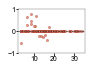

In [5]:
#sort dataframe to only label outliers
df_toplot_s = df_toplot.iloc[(-df_toplot['epistasis'].abs()).argsort()].reset_index(drop=True)

#number of outliers to label
if antigen=="H1":
    spot = "darksalmon"
    edge = "maroon"
elif antigen=="H3":
    spot = "mediumaquamarine"
    edge = "teal"
lim = 5
%matplotlib inline
import matplotlib as mpl
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.25
fig, ax = plt.subplots(figsize=(1.2,0.8))
plt.tick_params(labelsize=7,length=2.5,pad=0.5)
#Create figure
# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(df_toplot_s.distance, df_toplot_s.epistasis, alpha = 1, linewidth=0.25,color=spot,edgecolor=edge,s=5,legend=False)

#plt.title('%s' % antigen,fontsize=8,weight='bold')
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.ylim(-1,1)
ax.set_xlabel('',fontsize=7,labelpad=0)
if plotting == "sum":
    ax.set_ylabel('weighted epistasis',fontsize=7)
else:
    ax.set_ylabel('',fontsize=7,labelpad=0)

plt.savefig('images/9114_%s_2ndorder_structure.png'% antigen, transparent=True, dpi=600,bbox_inches='tight')

### Bin by distances for SI Fig #

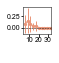

In [6]:
df_toplot_pos = df_toplot_s.copy()
df_toplot_pos['epistasis']=df_toplot_pos['epistasis'].abs()

plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(0.5,0.5))
plt.tick_params(labelsize=7,length=2.5,pad=0.1)
y = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['epistasis'].mean()
yerr = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['epistasis'].std()
x = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['distance'].mean()
plt.scatter(x,y,color=spot,s=5)
plt.errorbar(x,y,yerr,color=spot,linewidth=1)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.xlabel(' ')
plt.ylabel('')
plt.savefig('images/9114_%s_2ndorder_structure_binned.png'% antigen, transparent=True, dpi=600,bbox_inches='tight')


### permute the distances for null expectation

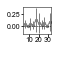

In [7]:
#permute for control
df_toplot_pos = df_toplot_s.copy()
df_toplot_pos['epistasis']=df_toplot_pos['epistasis'].abs()
df_toplot_pos['permuted'] = np.random.permutation(df_toplot_pos['distance'].values)
fig, ax = plt.subplots(figsize=(0.5,0.5))
plt.tick_params(labelsize=7,length=2.5,pad=0.1)
y = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['epistasis'].mean()
yerr = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['epistasis'].std()
x = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['permuted'].mean()
plt.scatter(x,y,color='gray',s=5)
plt.errorbar(x,y,yerr,color='gray',linewidth=1)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.xlabel(' ')
plt.ylabel('')
plt.savefig('images/9114_%s_2ndorder_structure_binned_permuted.png'% antigen, transparent=True, dpi=600,bbox_inches='tight')
